In [1]:
using JuMP
using LinearAlgebra
using Plots

import Ipopt

In [2]:
#INITIALISATIONS
# Constants
# (Maximum) speeds
vm_p = 2.0
vm_e = 1.0


# Max curvatures
um_p = 1.0      
um_e = 1.0

l = 0.05 ## Capture distance

x_p0 = 0
y_p0 = 0
th_p0 = pi/2

x_e0 = 0
y_e0 = 7
th_e0 = -pi/2

n = 200    # Time steps for PURSUER optimisation
tmin = (2*pi*0.6)/vm_p
tmax = 10

N = 200  # Time steps for EVADER optimisation


200

In [3]:
#INITIALIZATIONS CONTD
#Fix an initial trajectory xe_0(T) of the evader

#Initializing Pursuer

pursuer = Model(Ipopt.Optimizer)
set_silent(pursuer)

# Decision variables
@variables(pursuer, begin
    tmin/n <= Δt <= tmax/n     # Time step                       # HEURISTICS NEEDED HERE

    ## State variables
    x_p[1:n]            
    y_p[1:n]        
    th_p[1:n]           # Orientation 
    ## Control variables
    -um_p ≤ u_p[1:n] ≤ um_p

    ## Evader's terminal position
    x_eT == x_e0
    y_eT
    th_eT == th_e0

end)

@objective(pursuer, Min, Δt)

fix(x_p[1], x_p0; force = true)
fix(y_p[1], y_p0; force = true)
fix(th_p[1], th_p0; force = true)

@constraint(pursuer, y_eT == y_e0-1*n*Δt)        #Initial Random trajectory

@NLconstraint(pursuer, (x_p[n]-x_eT)^2 + (y_p[n]-y_eT)^2 <= l*l)

## Dynamics

for j in 2:n 

    @NLconstraint(pursuer, x_p[j] == x_p[j - 1] + Δt *0.5* vm_p*(cos(th_p[j - 1])+cos(th_p[j])))
    ## Trapezoidal integration
    @NLconstraint(pursuer, y_p[j] == y_p[j - 1] + Δt *0.5* vm_p*(sin(th_p[j - 1])+sin(th_p[j])))
    ## Trapezoidal integration
    @NLconstraint(pursuer, th_p[j] == th_p[j - 1] + 0.5*Δt *vm_p* (u_p[j]+u_p[j-1]))
    ## Trapezoidal integration

end

## Solve PD to obtain e_0, T_0 and α_0
println("Solving...")
optimize!(pursuer)
solution_summary(pursuer)

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



* Solver : Ipopt

* Status
  Termination status : LOCALLY_SOLVED
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution
  Objective value      : 0.01162207590874697

* Work counters
  Solve time (sec)   : 3.45721


In [4]:
#T_0
println("Time taken: ", n*objective_value(pursuer))

Time taken: 2.3244151817493943


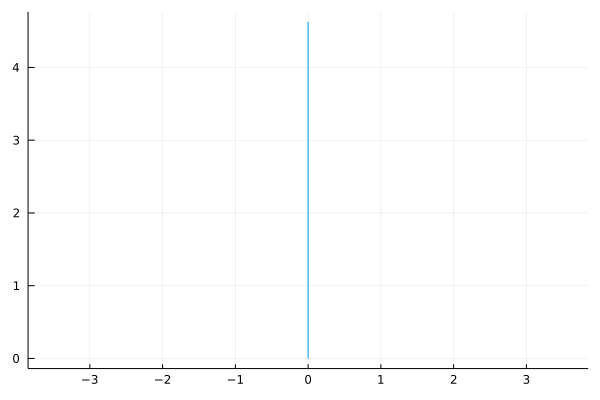

In [5]:
Plots.plot(value.(x_p),value.(y_p),fmt=:png,aspect_ratio = 1,legend = false)


In [6]:
#e_0
(value.(x_eT), value.(y_eT))

(0.0, 4.675584818250606)

In [7]:
print(value.(u_p))

[-1.4342076646795535e-14, -1.5272236653376073e-14, 1.6115509666846595e-15, 3.1541812671428256e-15, 7.438039497321187e-16, 1.6849093465722859e-15, 3.505290372500553e-15, 3.6325263200404076e-15, 3.2009621899679977e-16, -1.7677378527697192e-15, -7.074135284949113e-16, -1.5730936682718201e-16, -3.5389054647501115e-16, 1.142477989432297e-15, 2.3613891588889033e-15, 1.82840765230327e-15, 2.5675452728815674e-15, 4.694197554894958e-16, -4.775348012438921e-16, 5.400979544485569e-16, 6.261325030535781e-16, -2.207811026861806e-15, 2.298482880352219e-16, 3.873997137186414e-16, -3.9248200743105085e-15, -2.338839102132427e-15, 3.6428800540640675e-16, 1.2831810690419114e-15, 1.7291672605788702e-15, -2.6481955244394977e-16, 7.484726868668642e-16, 3.068917783669966e-15, 9.836103918109858e-16, 1.1521529428027477e-15, 1.4392819432454412e-15, 1.3834360698120974e-15, 1.4599972205756773e-15, -1.062012106116977e-15, -3.554384015985163e-15, -2.4116723920646663e-15, 2.098417149453838e-15, 6.519203687780186e-16

In [8]:
value.(x_p[n]), value.(y_p[n])

(2.1104765971590904e-15, 4.62558621168129)

Solving Evader...


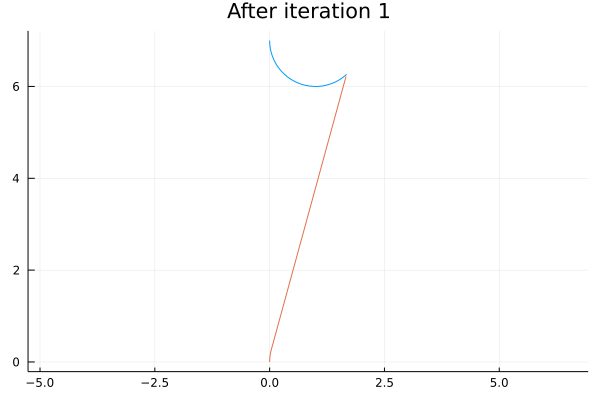

Solving Pursuer...
Solving Evader...


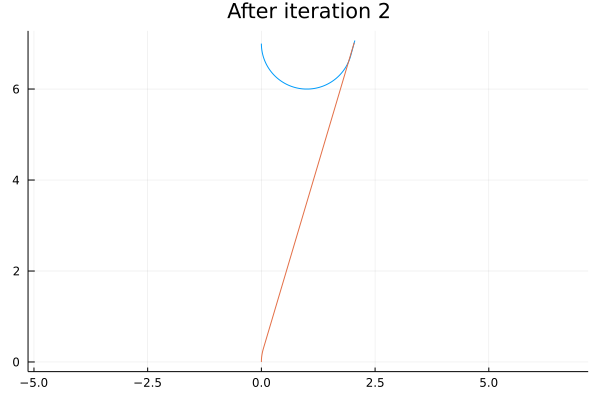

Solving Pursuer...


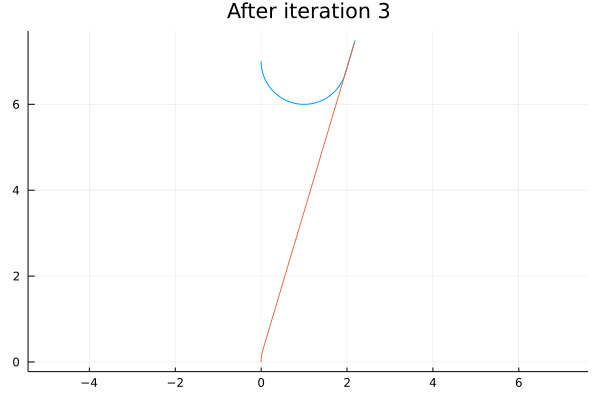

Solving Evader...
Solving Pursuer...
Solving Evader...


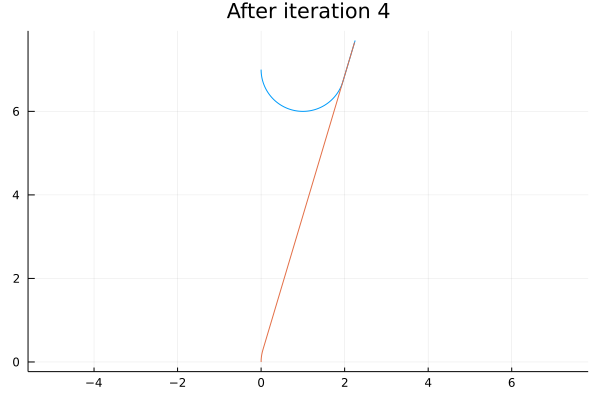

Solving Pursuer...


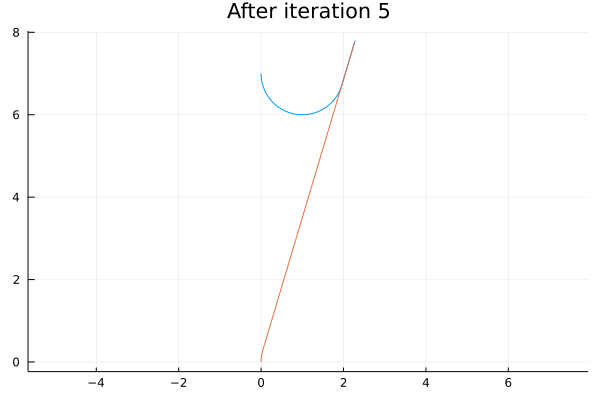

Solving Evader...
Solving Pursuer...


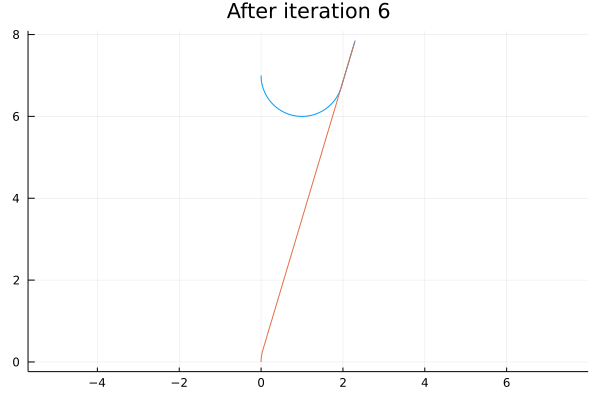

Solving Evader...
Solving Pursuer...


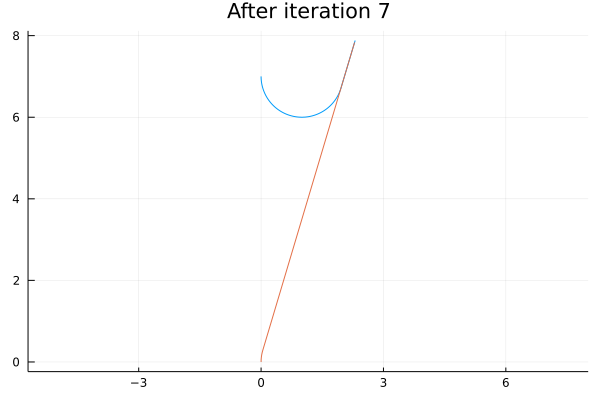

Solving Evader...
Solving Pursuer...
Solving Evader...


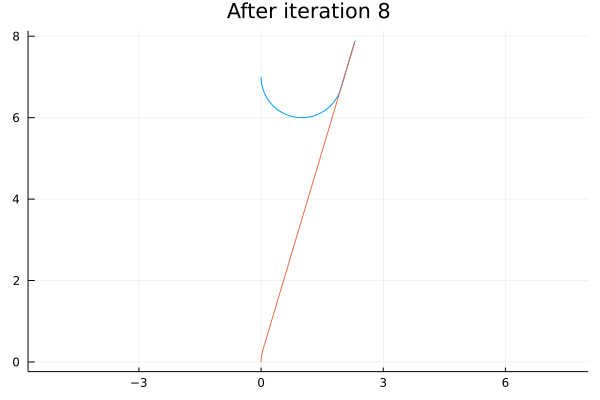

Solving Pursuer...


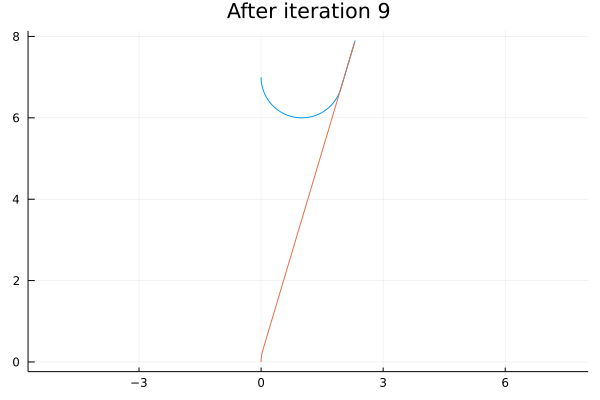

Solving Evader...
Solving Pursuer...


In [9]:
threshold = 0.0001   ## ------------------- NEED TO TUNE THIS
condition = true
iter = 1

X_e,Y_e,Th_e,U_e = [],[],[],[]
t = []

while condition # ------- Try to keep what all is possible out of the loop


    ## ------------------------------------- EVADER PART -------------------------------------
    #Solve ED using e_k, T_k and α_k
    evader = Model(Ipopt.Optimizer)
    set_silent(evader)

    # CONSTANTS here
    Δt = value.(Δt)
    #expression for α
    denom_first = dot([2*value.(x_p[n]-x_eT) 2*value.(y_p[n]-y_eT)], [vm_p*cos(value.(th_p[n])) vm_p*sin(value.(th_p[n]))])
    denom_second = dot(-[2*value.(x_p[n]-x_eT) 2*value.(y_p[n]-y_eT)], [vm_e*cos(value.(th_eT)) vm_e*sin(value.(th_eT))])

    α = -1/(denom_first+denom_second)

    #quantities required for objective function
    dlbyde = [2*value.(x_eT-x_p[n]) 2*value.(y_eT-y_p[n])]
    first_term = α*dlbyde

    # Decision variables
    @variables(evader, begin

        ## State variables
        x_e[1:N]            
        y_e[1:N]        
        th_e[1:N]           # Orientation 
        ## Control variables
        -um_e ≤ u_e[1:N] ≤ um_e
    end)

    fix(x_e[1], x_e0; force = true)
    fix(y_e[1], y_e0; force = true)
    fix(th_e[1], th_e0; force = true)

    ## Dynamics

    for j in 2:N

        @NLconstraint(evader, x_e[j] == x_e[j - 1] + Δt *0.5* vm_e*(cos(th_e[j - 1])+cos(th_e[j])))
        ## Trapezoidal integration
        @NLconstraint(evader, y_e[j] == y_e[j - 1] + Δt *0.5* vm_e*(sin(th_e[j - 1])+sin(th_e[j])))
        ## Trapezoidal integration
        @NLconstraint(evader, th_e[j] == th_e[j - 1] + 0.5*Δt *vm_e* (u_e[j]+u_e[j-1]))
        ## Trapezoidal integration

    end

    @objective(evader, Max, (x_e[N]-value.(x_eT))*first_term[1] + (y_e[N]-value.(y_eT))*first_term[2])

    println("Solving Evader...")
    optimize!(evader)

    #Δt_opt = Δt      # Δt found after previous pursuer optimisation

    x_eT_prev, y_eT_prev = x_eT, y_eT

    ## --------------------------------------PURSUER PART-------------------------------------------
    pursuer = Model(Ipopt.Optimizer)
    set_silent(pursuer)

    ## Evader's terminal position
    x_eT = value.(x_e[N])
    y_eT = value.(y_e[N])
    th_eT = value.(th_e[N])


    # Decision variables

    @variables(pursuer, begin
        tmin/n <= Δt <= tmax/n     # Time step                       # HEURISTICS NEEDED HERE

        ## State variables
        x_p[1:n]            
        y_p[1:n]        
        th_p[1:n]           # Orientation 
        ## Control variables
        -um_p ≤ u_p[1:n] ≤ um_p
        
    end)

    @objective(pursuer, Min, Δt)

    fix(x_p[1], x_p0; force = true)
    fix(y_p[1], y_p0; force = true)
    fix(th_p[1], th_p0; force = true)


    @NLconstraint(pursuer, (x_p[n]-x_eT)^2 + (y_p[n]-y_eT)^2 <= l*l)

    ## Dynamics

    for j in 2:n

        @NLconstraint(pursuer, x_p[j] == x_p[j - 1] + Δt *0.5* vm_p*(cos(th_p[j - 1])+cos(th_p[j])))
        ## Trapezoidal integration
        @NLconstraint(pursuer, y_p[j] == y_p[j - 1] + Δt *0.5* vm_p*(sin(th_p[j - 1])+sin(th_p[j])))
        ## Trapezoidal integration
        @NLconstraint(pursuer, th_p[j] == th_p[j - 1] + 0.5*Δt *vm_p* (u_p[j]+u_p[j-1]))
        ## Trapezoidal integration

    end

    #Solve PD using the extended solution to obtain e_(k+1), T_(k+1), α_(k+1)
    println("Solving Pursuer...")
    optimize!(pursuer)

    #Plotting both of them together
    x = [value.(x_e) value.(x_p)]; y = [value.(y_e) value.(y_p)]

    title = string("After iteration ",iter)
    fig = plot(x, y, title = title,fmt=:png, label = ["Evader" "Pursuer"], legend = false, aspect_ratio = 1)
    display(fig)
    
    iter = iter + 1
    condition = (value.(x_eT_prev-x_eT))^2+(value.(y_eT_prev-y_eT))^2 > threshold
    
    push!(t,value.(Δt)*n)
    
    if condition == false
        X_e,Y_e,Th_e,U_e = value.(x_e),value.(y_e),value.(th_e),value.(u_e)
    end
end

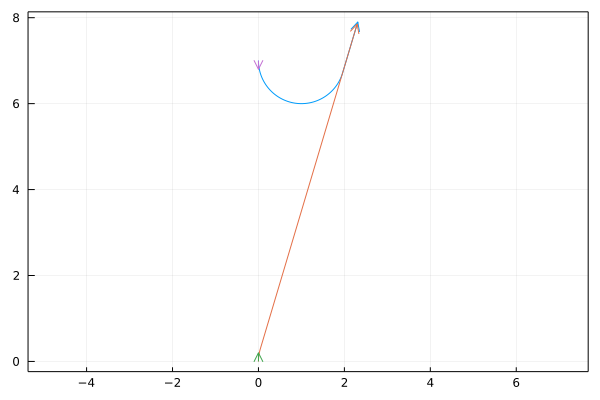

In [55]:
arrow_len = 0.2
xp_arrow, yp_arrow = zeros(200), 0:arrow_len/199:arrow_len
xe_arrow, ye_arrow = x_e0.+xp_arrow, y_e0.-yp_arrow

x = [X_e value.(x_p) xp_arrow xe_arrow]; y = [Y_e value.(y_p) yp_arrow ye_arrow]

fig = plot(x, y, fmt=:png, label = ["Evader" "Pursuer"], legend = false, aspect_ratio = 1, framestyle = :box, arrow = true)
display(fig)

In [56]:
Plots.savefig(fig,"yash_0comma7commaMinus90pursuer90.pdf")

In [79]:
print(value.(u_p))

[0.9999730578399973, 0.9999867609865486, 0.9999871876278111, 0.9999875768721825, 0.9999879320147973, 0.9999882559439861, 0.9999885511959529, 0.9999888200007079, 0.9999890643207833, 0.9999892858839553, 0.9999894862109685, 0.999989666639065, 0.9999898283419779, 0.9999899723469238, 0.9999900995490358, 0.999990210723598, 0.9999903065363748, 0.9999903875522834, 0.999990454242602, 0.9999905069908773, 0.9999905460976604, 0.9999905717841718, 0.999990584194973, 0.9999905833996995, 0.9999905693938934, 0.9999905420989494, 0.9999905013611765, 0.9999904469499528, 0.9999903785549379, 0.9999902957822836, 0.999990198149763, 0.9999900850807126, 0.9999899558966576, 0.999989809808451, 0.9999896459057281, 0.9999894631444243, 0.9999892603320537, 0.9999890361103801, 0.9999887889350286, 0.9999885170514868, 0.9999882184668258, 0.9999878909163111, 0.999987531823888, 0.9999871382552813, 0.9999867068621459, 0.9999862338153129, 0.9999857147246801, 0.9999851445426475, 0.9999845174471667, 0.9999838266993715, 0.9999

In [92]:
t

7-element Vector{Any}:
 3.6594161755745356
 4.3151486098603975
 4.781168356559211
 5.0
 5.0
 5.0
 5.0

In [90]:
print(t)

Any[2.2456510813791764, 1.2566370614359172, 1.2566370614359172, 2.483215199071524, 1.2566370614359172, 1.2566370614359172, 2.4832151990719478, 1.2566370614359172, 1.2566370614359172, 2.483215199071947, 1.2566370614359172, 1.2566370614359172]

In [389]:
using CSV, DataFrames

matrix = hcat(value.(x_p),value.(y_p),value.(th_p),value.(u_p),X_e,Y_e,Th_e,U_e)

CSV.write("home/twoCarsData.csv", DataFrame(matrix, :auto),header = false, append = true)

"D:\\Julia\\data\\twoCarsDataNear.csv"